# Experiment 02: N_cities

Evaluating the impact of the autoencoder with different number of cities.

P.S.: not doing any domain shift yet.

In [1]:
import os
from os import path as osp
# if 'jupyter' in os.getcwd():
#     os.chdir(osp.join(os.getcwd(), 'masterarbeit', 'code'))
import glob
import time
import argparse
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdmnotebook
import pickle
from pathlib import Path
from typing import Any
from typing import Callable
from typing import Optional
from typing import Tuple
from typing import Union
from typing import Dict
from typing import List
from itertools import cycle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
mpl.rc('axes', unicode_minus=False)
preamble = r'\usepackage{amsmath}'  # LaTeX preamble command
mpl.rcParams['text.latex.preamble'] = preamble

# import seaborn as sns
import networkx as nx
import math
import numpy as np

# pytorch imports
import torch
from torch import Tensor, nn, cuda
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.cuda.amp import GradScaler, autocast

# pytorch geometric imports
import torch_geometric
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import Compose

from torch_geometric_temporal import GConvLSTM

# lightning imports
from lightning.pytorch.utilities.combined_loader import CombinedLoader

from google.cloud import storage

import sys
# Add the 'code' directory to sys.path to make the  submodules available
# sys.path.append('/home/jupyter/masterarbeit/code')

from util.utils import generate_log_name
from util.plot_utils import *

import logging as log

from data.dataset.GraphDataset import GraphDataset

from model.transform import CollapseChannels, ExtractSquare
from model.autoencoder import Autoencoder

from model.criterions import WeightedMSELoss, MSLELoss, FocalLoss, ZeroInflatedLoss, CustomHuberLoss

In [2]:
exp_id = 'exp02'

In [3]:
NUM_WORKERS: int = 0
BATCH_SIZE: int = 8
NUM_CHANNELS: int = 2
WDW_LENGTH: list = [12, 6]

# Constants that I may change a bit during testing
tgt: str = 'MELBOURNE'
src_list: list = ['ANTWERP', 'BANGKOK']
# src_list: list = ['ANTWERP', 'BANGKOK', 'BARCELONA', 'BERLIN', 'CHICAGO', 'ISTANBUL', 'MOSCOW'] # 7 cities
EPOCHS_OFFLINE: int = 2
tgt_data_limit: int = 1680
src_data_limit: int = None
LOGGING: int = 1

In [4]:
if src_data_limit == -1:
    src_data_limit = None

# Get data from bucket
bucket_name = 'cloud-ai-platform-054ad037-69b6-4c4d-94a1-75d2591213c7'
bucket_folder = 'data/graphs'
local_folder  = 'data/graphs'
download_directory(bucket_name, bucket_folder, local_folder)
bucket_folder = 'data/raw'
local_folder  = 'data/raw'
download_directory(bucket_name, bucket_folder, local_folder)

bucket_output = 'output/models/'

In [5]:
# Constants that I don't intend to change much
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TRAIN_VAL_TEST_SPLIT = [0.8, 0.1, 0.1]

pre_transform = Compose([
    CollapseChannels(),
    ExtractSquare(50, 'central'),
])

static_transform = Compose([
    ExtractSquare(50, 'central'),
])

ds_kwargs = {
    'root_dir': 'data/raw',
    'device': device,
    'pre_transform': pre_transform,
    'static_transform': static_transform,
}

In [6]:
AE_criterion   = WeightedMSELoss(weight=100)

N_city=8_conv_dim=16_num_channels=2_K_cheb=2_device=device(type='cuda')_activation='relu'_dropout=0.5_linear_dim=8


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/4321 [00:00<?, ?it/s]

Batches:   0%|          | 0/4321 [00:00<?, ?it/s]

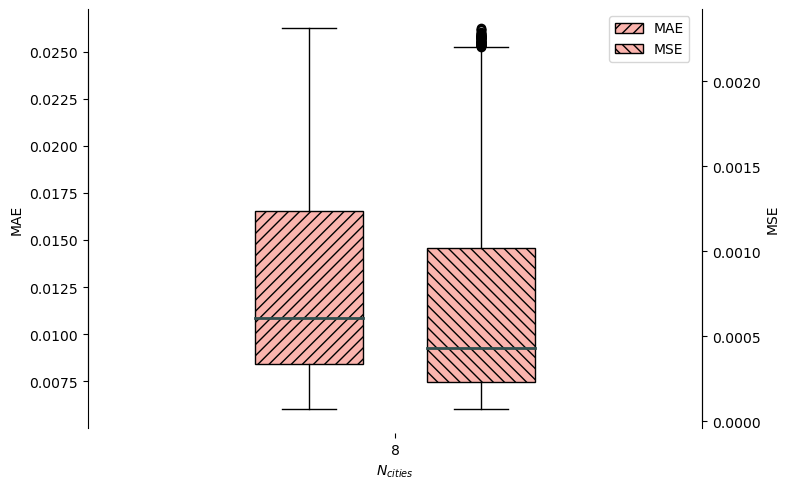

N_city=4_conv_dim=16_num_channels=2_K_cheb=2_device=device(type='cuda')_activation='relu'_dropout=0.5_linear_dim=8


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/4321 [00:00<?, ?it/s]

Batches:   0%|          | 0/4321 [00:00<?, ?it/s]

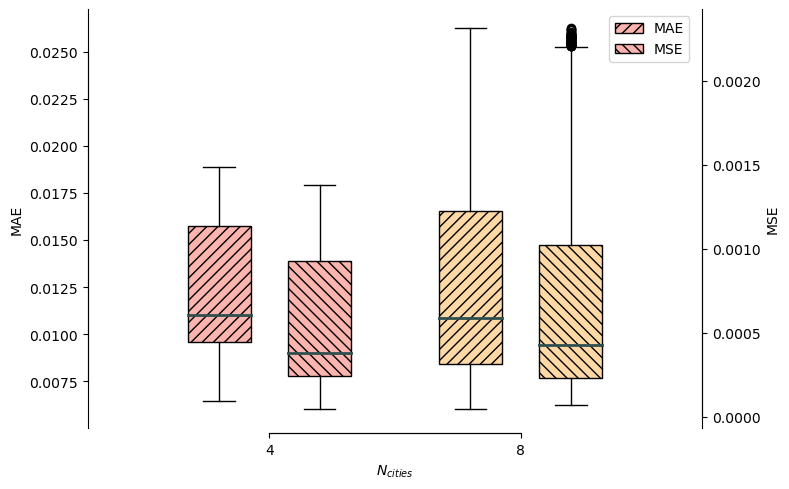

N_city=2_conv_dim=16_num_channels=2_K_cheb=2_device=device(type='cuda')_activation='relu'_dropout=0.5_linear_dim=8


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/4321 [00:00<?, ?it/s]

Batches:   0%|          | 0/4321 [00:00<?, ?it/s]

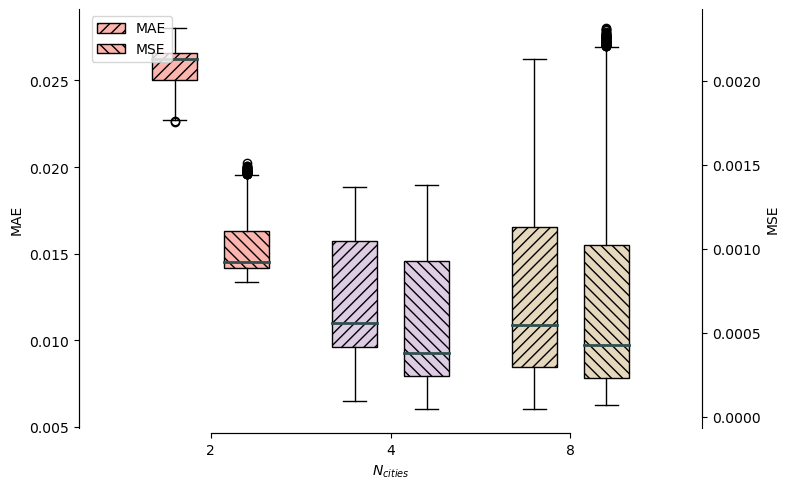

N_city=1_conv_dim=16_num_channels=2_K_cheb=2_device=device(type='cuda')_activation='relu'_dropout=0.5_linear_dim=8


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/4321 [00:00<?, ?it/s]

Batches:   0%|          | 0/4321 [00:00<?, ?it/s]

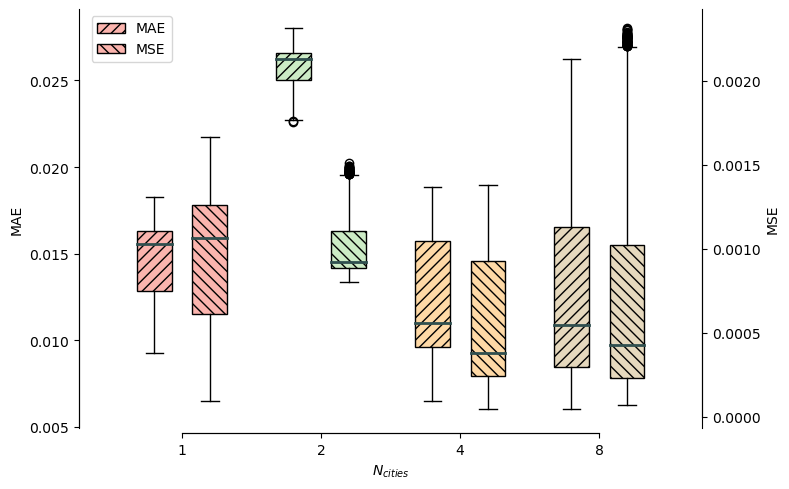

<Figure size 800x500 with 0 Axes>

In [7]:
conv_dim=16
linear_dim=8
num_channels=NUM_CHANNELS
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
activation='relu'
dropout=0.5
K_cheb=3

N_cities = [8, 4, 2, 1]

src_list: list = ['ANTWERP', 'BANGKOK', 'BARCELONA', 'BERLIN', 'CHICAGO', 'ISTANBUL', 'MOSCOW', 'MELBOURNE']

test_losses_dict = {}
for N_city in N_cities:
    torch.cuda.empty_cache()
    new_src_list = src_list[:N_city]
    # Create datasets for each city
    ds_dict = {}
    for city in new_src_list:
        ds_dict[city] = GraphDataset(
            cities=[city],
            limit=src_data_limit,
            **ds_kwargs,
        )
    # Split each dataset into training and test sets
    train = {}
    val   = {}
    test  = {}
    for city in ds_dict:
        train_ds, val_ds, test_ds = random_split(
            ds_dict[city], TRAIN_VAL_TEST_SPLIT
        )
        train[city] = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
        val[city]   = DataLoader(  val_ds, batch_size=BATCH_SIZE, shuffle=True)
        test[city]  = DataLoader( test_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Create dataloader for offline training with source cities
    source_train = {city: train[city] for city in new_src_list}
    source_dataloader = CombinedLoader(source_train, mode='max_size_cycle')

    source_test = {city: test[city] for city in new_src_list}
    sourcetest_dataloader = CombinedLoader(source_test, mode='max_size_cycle')

    specs = f'{N_city=}_{conv_dim=}_{num_channels=}_{K_cheb=}_{device=}_{activation=}_{dropout=}_{linear_dim=}'
    print(specs)
    ae = Autoencoder(conv_dim=conv_dim,
                     num_channels=num_channels,
                     K_cheb=K_cheb,
                     device=device,
                     activation=activation,
                     dropout=dropout,
                     linear_dim=linear_dim,
                     ).to(device)

    lr = 5e-3
    l2_decay = 5e-4

    optimizer = torch.optim.Adam([
        {'params': ae.parameters()},
        ], lr=lr, weight_decay=l2_decay)

    scaler = GradScaler()
    tqdm_bar_fmt = '{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]'
    len_train = source_dataloader._dataset_length()//BATCH_SIZE + 1

    ae.train()
    # fn = generate_log_name(prefix="autoencoder", fdir="training logs")
    # log.basicConfig(filename=osp.join('training logs', fn), level=log.INFO)
    # Initialize lists to store losses
    train_losses = []
    val_losses = []
    test_losses = []

    # Outer progress bar for epochs
    with tqdmnotebook(total=EPOCHS_OFFLINE,
                      leave=True,
                      # mininterval=20,
                      desc='Epochs',
                      colour='blue',
                      bar_format=tqdm_bar_fmt) as pbar_epochs:
        for epoch in range(EPOCHS_OFFLINE):
            with tqdmnotebook(
                total=len_train,
                leave=True,
                # mininterval=20,
                desc='Batches',
                colour='green',
                bar_format=tqdm_bar_fmt) as pbar_batches:
                for databatch, i, _ in source_dataloader:
                    total_loss = 0
                    for city, data in databatch.items():
                        x, edge_index, batch = data.x, data.edge_index, data.batch
                        with torch.cuda.amp.autocast():
                            x_recons = ae(x, edge_index)
                            x = x.reshape(x_recons.shape)
                            loss = AE_criterion(x_recons, x)
                        total_loss += loss
                    # Scales loss and calls backward() to create scaled gradients
                    scaler.scale(total_loss).backward(retain_graph=True)

                    # Unscales gradients and calls optimizer.step()
                    scaler.step(optimizer)

                    # Updates the scale for next iteration
                    scaler.update()
                    train_losses.append(total_loss.item())
                    # Zero the gradients
                    optimizer.zero_grad()
                    pbar_batches.update(1)
            # reconstruction_plot(x, x_recons, specs=specs, save=True, show=True, exp_id=exp_id)
            pbar_epochs.update(1)

    # train_losses_dict[N_city] = train_losses

    # reconstruction_plot(x, x_recons, specs=specs, save=False, show=True)
    folder = osp.join('training logs', 'models', exp_id)
    check_dir(folder)
    torch.save(ae.state_dict(), osp.join(folder, f'{N_city}.pth'))
        # After all epochs
    ae.eval()
    # total_test_loss = 0
    # test_losses = []
    errors = {
        'MAE': torch.empty(0, device=device, dtype=torch.float16), 
        'MSE': torch.empty(0, device=device, dtype=torch.float16)
    }
    with torch.no_grad():
        for databatch, i, _ in sourcetest_dataloader:
            for city, data in databatch.items():
                batch_size = int(data.ptr.shape[0] - 1)
                x, edge_index = data.x, data.edge_index
                x_recons = ae(x, edge_index)
                
                x = x.reshape(batch_size, -1)
                x_recons = x_recons.reshape(batch_size, -1)
                
                mae = torch.mean(torch.abs(x - x_recons), dim=1)
                mse = torch.mean(torch.square(x - x_recons), dim=1)
                
                errors['MAE'] = torch.cat([errors['MAE'], mae], dim=0)
                errors['MSE'] = torch.cat([errors['MSE'], mse], dim=0)
    
    test_losses_dict[N_city] = errors
    plot_losses_boxplot(test_losses_dict, variable=r'$N_{cities}$', 
                        errors=['MAE', 'MSE'], specs="", save=False, show=True,
                        exp_id=exp_id)
    
plot_losses_boxplot(test_losses_dict, variable=r'$N_{cities}$', 
                    errors=['MAE', 'MSE'], specs=specs, save=True, show=True,
                    exp_id=exp_id)